## Part 1: Trend Analysis

1. Analyse trend of goals per season. For example total goals per match, average goals per match.


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter

In [4]:
bundesliga = pd.read_csv('bundesliga.csv')
bundesliga.head()

,SEASON,LEAGUE,DATE,HOMETEAM,AWAYTEAM,FTSC,FTHG,FTAG,FTTG
0,1994,Bundesliga 1,1993-08-07,Bayern Munich,Freiburg,3-1,3,1,4
1,1994,Bundesliga 1,1993-08-07,Dortmund,Karlsruhe,2-1,2,1,3
2,1994,Bundesliga 1,1993-08-07,Duisburg,Leverkusen,2-2,2,2,4
3,1994,Bundesliga 1,1993-08-07,FC Koln,Kaiserslautern,0-2,0,2,2
4,1994,Bundesliga 1,1993-08-07,Hamburg,Nurnberg,5-2,5,2,7


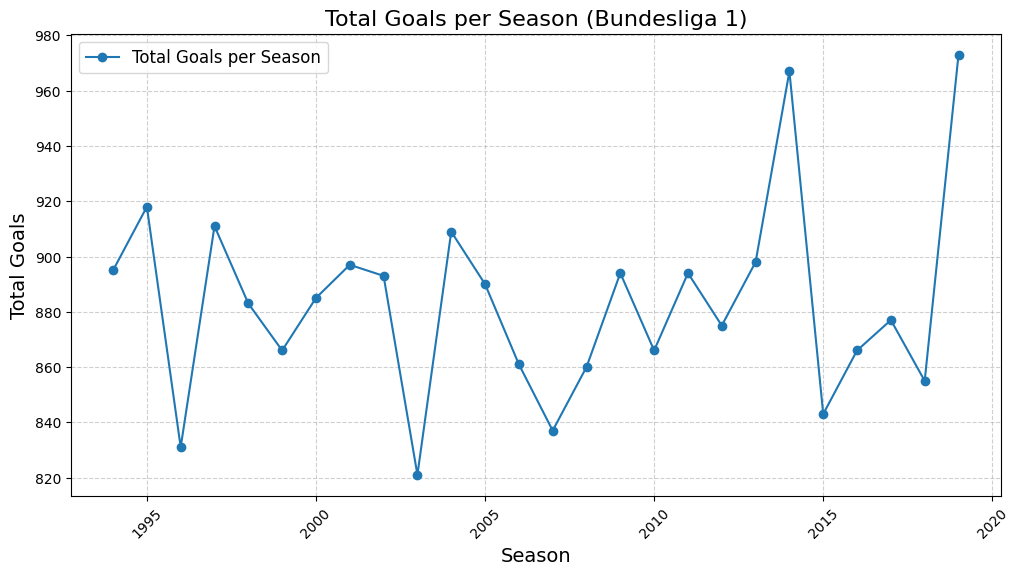

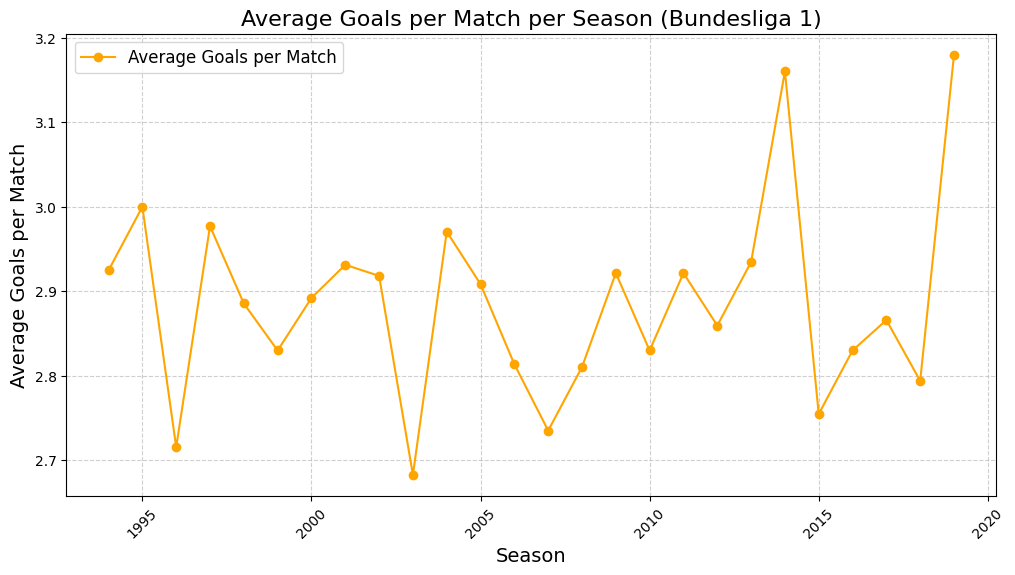

In [31]:
goals_per_season = bundesliga.groupby("SEASON")['FTTG'].sum()
avg_goals_per_match = bundesliga.groupby("SEASON")['FTTG'].mean()

plt.figure(figsize=(12, 6))
plt.plot(goals_per_season, marker='o', label='Total Goals per Season')
plt.title('Total Goals per Season (Bundesliga 1)', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Total Goals', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(avg_goals_per_match, marker='o', color='orange', label='Average Goals per Match')
plt.title('Average Goals per Match per Season (Bundesliga 1)', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Average Goals per Match', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.show()

2. Goal Distribution Per Season. Use appropriate type of graphs for goals per match, year-wise. Colorcode by whether average is above or below 2.5 (over/under bet threshold).

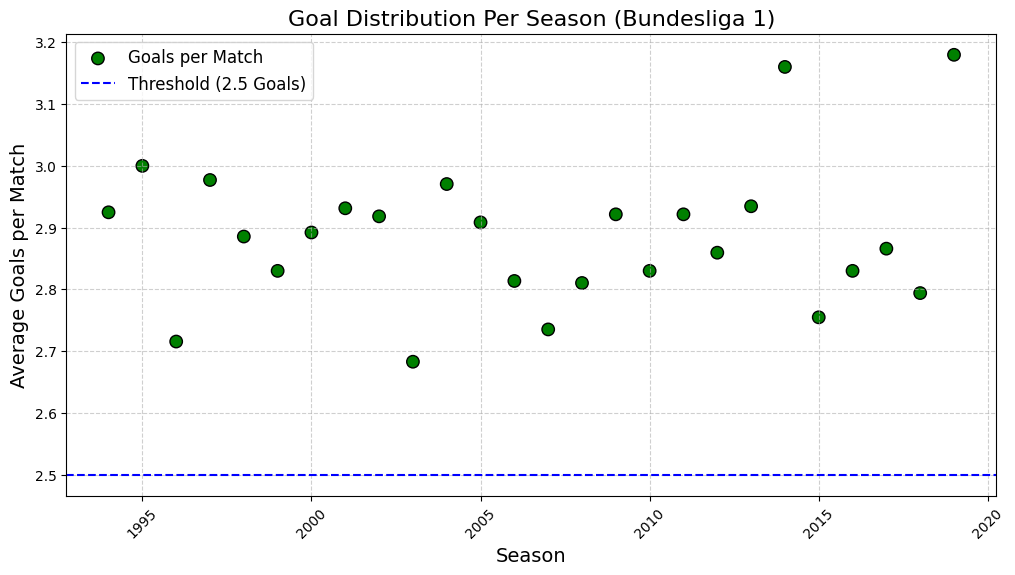

In [35]:
avg_goals_per_match = bundesliga.groupby("SEASON")['FTTG'].mean()

goal_distribution = pd.DataFrame({
    'Season': avg_goals_per_match.index,
    'Average Goals': avg_goals_per_match.values,
    'Above 2.5': avg_goals_per_match.values > 2.5
})

colors = goal_distribution['Above 2.5'].map({True: 'green', False: 'red'})

plt.figure(figsize=(12, 6))
plt.scatter(goal_distribution['Season'], goal_distribution['Average Goals'], c=colors, s=80, edgecolors='black', label='Goals per Match')

plt.axhline(2.5, color='blue', linestyle='--', linewidth=1.5, label='Threshold (2.5 Goals)')

plt.title('Goal Distribution Per Season (Bundesliga 1)', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Average Goals per Match', fontsize=14)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

3. Create line charts for each season. Visualize trend of goals for each team that played in that season.
Highlight only Bayern Munchen with red color. Rest should be gray. Add appropriate title that will
contain information about season and total scored goals. Add footnote mentioning total number of
goals scored by Bayern Munchen for that season.

In [51]:
def visualize_goals_per_season(season):
    season_data = bundesliga[bundesliga['SEASON'] == season]
    
    teams = pd.concat([season_data['HOMETEAM'], season_data['AWAYTEAM']], ignore_index=True)
    goals = pd.concat([season_data['FTHG'], season_data['FTAG']], ignore_index=True)
    team_goals = pd.DataFrame({'Team': teams, 'Goals': goals}).groupby('Team').sum().reset_index()

    colors = ['red' if team == 'Bayern Munich' else 'gray' for team in team_goals['Team']]

    total_goals = team_goals['Goals'].sum()
    bayern_goals = team_goals[team_goals['Team'] == 'Bayern Munich']['Goals'].sum() if 'Bayern Munich' in team_goals['Team'].values else 0

    plt.figure(figsize=(12, 6))
    plt.plot(team_goals['Team'], team_goals['Goals'], color='gray', linestyle='-', alpha=0.8)
    plt.scatter(team_goals['Team'], team_goals['Goals'], color=colors, s=100, edgecolors='black')
    plt.title(f"{season} Bundesliga Goals Trend (Total Goals: {total_goals})", fontsize=16)
    plt.xlabel('Team', fontsize=14)
    plt.ylabel('Goals', fontsize=14)
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.figtext(0.5, -0.1, f"Total goals scored by Bayern Munich: {bayern_goals}", fontsize=12, ha='center')
    plt.tight_layout()

    output_png = f"plot_{season}.png"
    plt.savefig(output_png)
    plt.close()
    return output_png

output_pdf = "part1-3-python.pdf"
pdf = canvas.Canvas(output_pdf, pagesize=letter)

for season in bundesliga['SEASON'].unique():
    png_file = visualize_goals_per_season(season)
    pdf.drawImage(png_file, x=30, y=100, width=550, height=400)  
    pdf.showPage()  
    
pdf.save()

## Part 2 Home Advantage Deconstructed 
1. Create Heatmap of Home vs. Away Wins per Team per Season

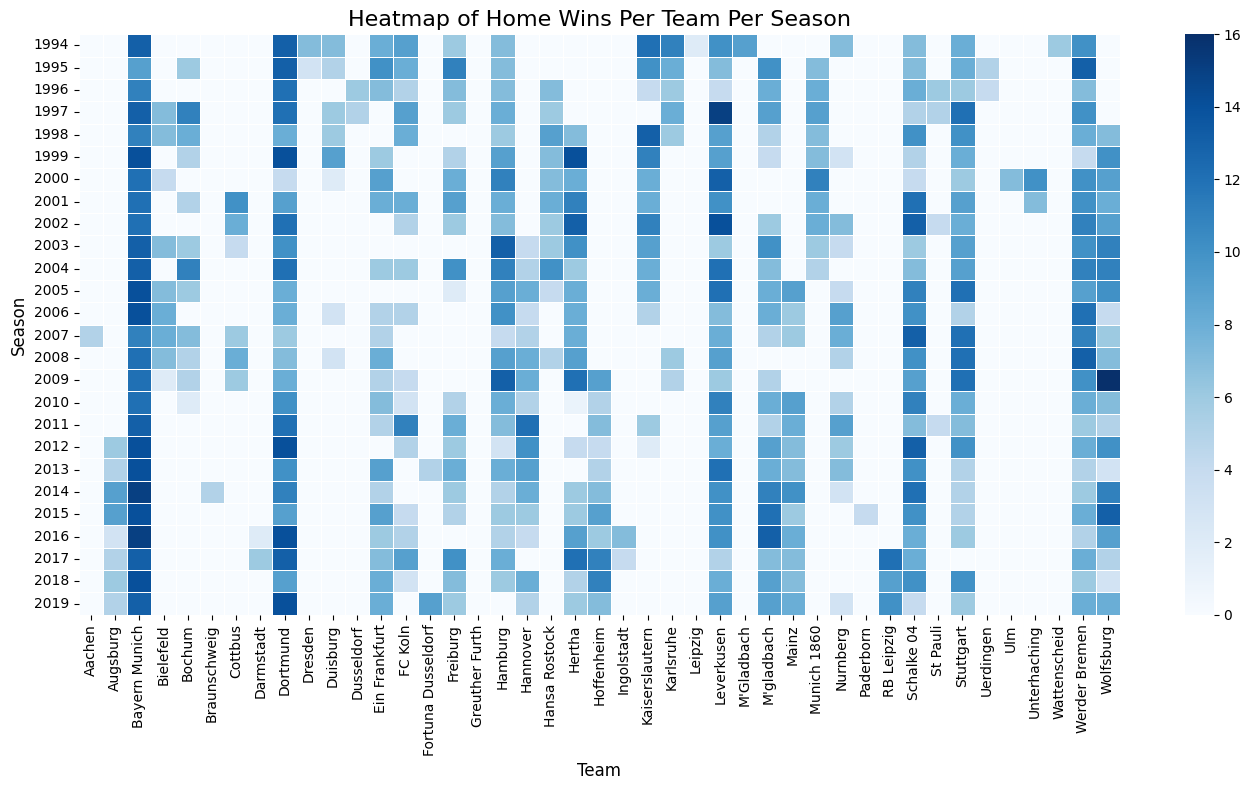

In [52]:
def process_wins(df):
    home_wins = df[df['FTSC'].str.split('-').apply(lambda x: int(x[0]) > int(x[1]))]
    home_wins = home_wins.groupby(['SEASON', 'HOMETEAM']).size().reset_index(name="HomeWins")
    
    away_wins = df[df['FTSC'].str.split('-').apply(lambda x: int(x[1]) > int(x[0]))]
    away_wins = away_wins.groupby(['SEASON', 'AWAYTEAM']).size().reset_index(name="AwayWins")
    
    home_wins.rename(columns={'HOMETEAM': 'Team'}, inplace=True)
    away_wins.rename(columns={'AWAYTEAM': 'Team'}, inplace=True)
    
    wins = pd.merge(home_wins, away_wins, on=['SEASON', 'Team'], how='outer').fillna(0)
    return wins

wins = process_wins(bundesliga)

wins_matrix = wins.pivot_table(index="SEASON", columns="Team", values="HomeWins", aggfunc="sum", fill_value=0)

plt.figure(figsize=(14, 8))
sns.heatmap(wins_matrix, cmap="Blues", annot=False, fmt="d", linewidths=0.5)
plt.title("Heatmap of Home Wins Per Team Per Season", fontsize=16)
plt.xlabel("Team", fontsize=12)
plt.ylabel("Season", fontsize=12)
plt.tight_layout()
plt.show()

2. Point Differential Density: Create visualizations that will show difference per team for home and away game wins

/var/folders/_1/__pt4n2j34s904855v8cbgkr0000gn/T/ipykernel_60330/2977549521.py:23: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(team_data, label=team, alpha=0.5, linewidth=1.5)
/var/folders/_1/__pt4n2j34s904855v8cbgkr0000gn/T/ipykernel_60330/2977549521.py:23: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(team_data, label=team, alpha=0.5, linewidth=1.5)
/var/folders/_1/__pt4n2j34s904855v8cbgkr0000gn/T/ipykernel_60330/2977549521.py:23: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(team_data, label=team, alpha=0.5, linewidth=1.5)
/var/folders/_1/__pt4n2j34s904855v8cbgkr0000gn/T/ipykernel_60330/2977549521.py:23: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(t

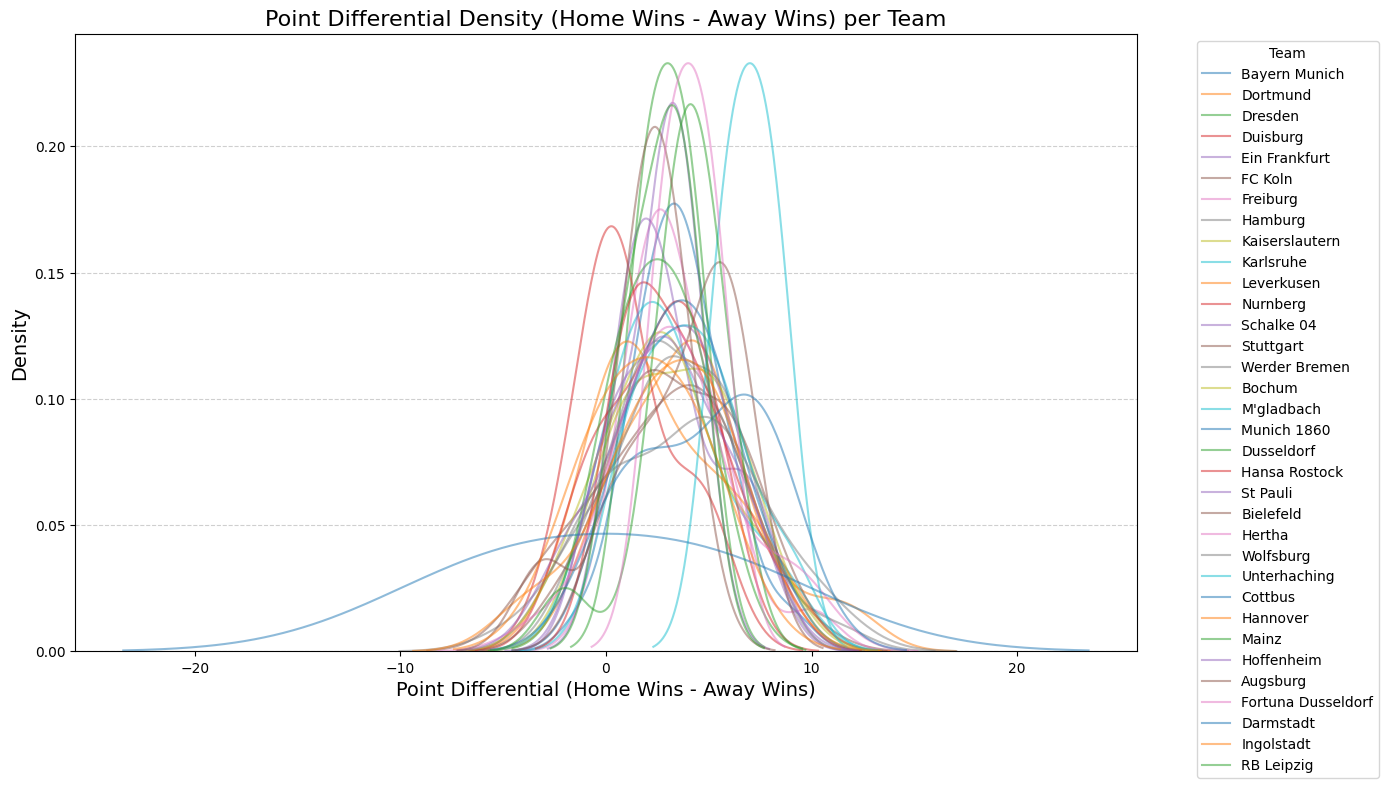

In [53]:
def process_point_differential(df):
    home_wins = df[df['FTSC'].str.split('-').apply(lambda x: int(x[0]) > int(x[1]))]
    home_wins = home_wins.groupby(['SEASON', 'HOMETEAM']).size().reset_index(name="HomeWins")
    
    away_wins = df[df['FTSC'].str.split('-').apply(lambda x: int(x[1]) > int(x[0]))]
    away_wins = away_wins.groupby(['SEASON', 'AWAYTEAM']).size().reset_index(name="AwayWins")
    
    home_wins.rename(columns={'HOMETEAM': 'Team'}, inplace=True)
    away_wins.rename(columns={'AWAYTEAM': 'Team'}, inplace=True)
    
    wins = pd.merge(home_wins, away_wins, on=['SEASON', 'Team'], how='outer').fillna(0)
    
    wins['PointDifferential'] = wins['HomeWins'] - wins['AwayWins']
    return wins

wins = process_point_differential(bundesliga)

plt.figure(figsize=(14, 8))

teams = wins['Team'].unique()
for team in teams:
    team_data = wins[wins['Team'] == team]['PointDifferential']
    sns.kdeplot(team_data, label=team, alpha=0.5, linewidth=1.5)

plt.title('Point Differential Density (Home Wins - Away Wins) per Team', fontsize=16)
plt.xlabel('Point Differential (Home Wins - Away Wins)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

## Part 3
1. Team Trajectories and Volatility

• Seasonal Position Trajectories

• Line plots showing seasonal ranks for top 6 teams.

• Annotate title-winning seasons.

In [54]:
bundesliga2 = pd.read_csv('bundesliga2.csv')
bundesliga2.head()

,TEAM,M,W,D,L,GF,GA,DIFF,POINTS,POSITION,SEASON
0,Bayern Munich,34,17,10,7,68,37,31,61,1,1994
1,Kaiserslautern,34,18,7,9,64,36,28,61,2,1994
2,Dortmund,34,15,9,10,49,45,4,54,3,1994
3,Ein Frankfurt,34,15,8,11,57,41,16,53,4,1994
4,Leverkusen,34,14,11,9,60,47,13,53,5,1994


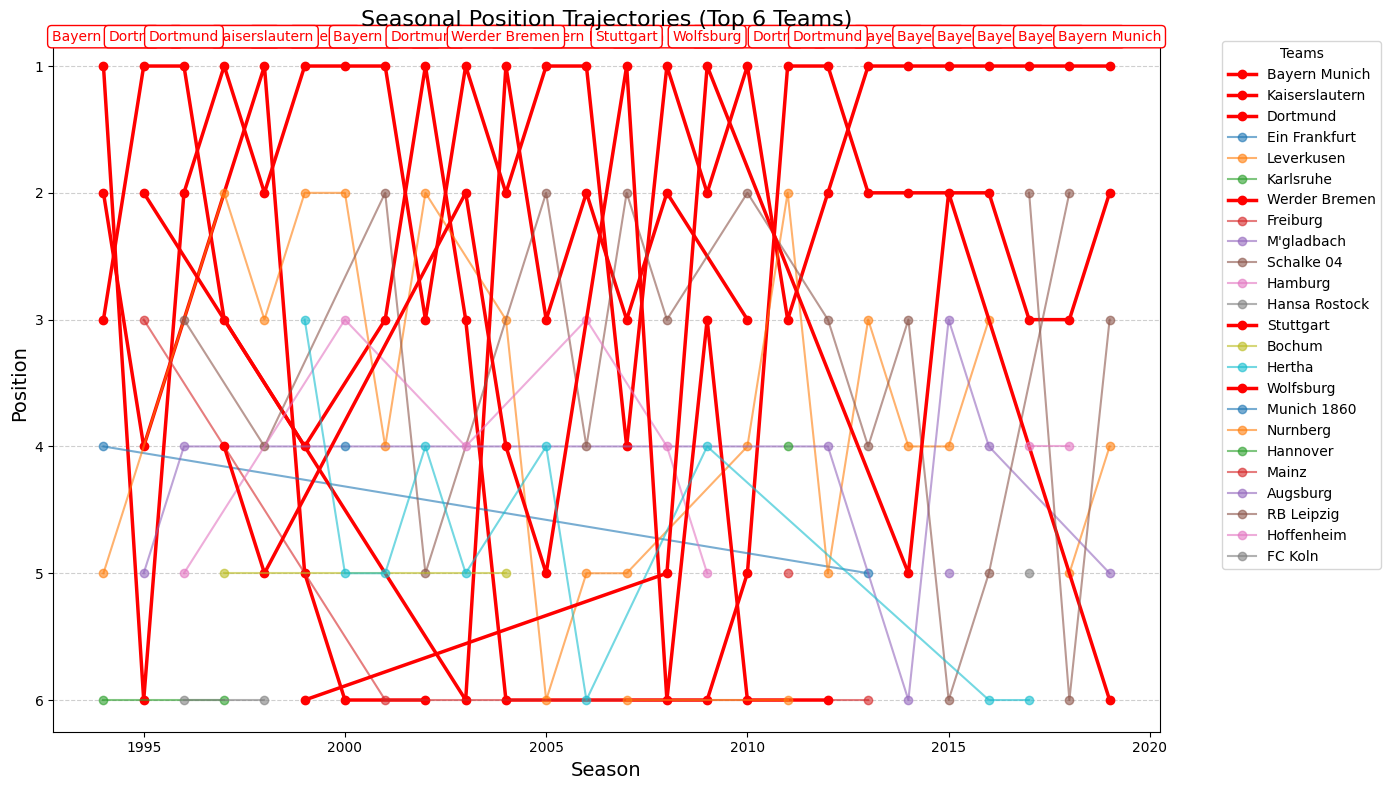

In [61]:
top_6_teams = bundesliga2[bundesliga2['POSITION'] <= 6]

title_winning_teams = bundesliga2[bundesliga2['POSITION'] == 1]

plt.figure(figsize=(14, 8))

for team in top_6_teams['TEAM'].unique():
    team_data = top_6_teams[top_6_teams['TEAM'] == team]
    if team in title_winning_teams['TEAM'].values:
        plt.plot(
            team_data['SEASON'], 
            team_data['POSITION'], 
            marker='o', 
            label=team, 
            color='red',
            linewidth=2.5
        )
        for _, row in title_winning_teams[title_winning_teams['TEAM'] == team].iterrows():
            plt.text(
                row['SEASON'], 
                row['POSITION'] - 0.2,
                row['TEAM'], 
                color='red', 
                fontsize=10,
                ha='center',
                bbox=dict(boxstyle="round,pad=0.3", edgecolor="red", facecolor="white")
            )
    else:
        plt.plot(
            team_data['SEASON'], 
            team_data['POSITION'], 
            marker='o', 
            label=team, 
            alpha=0.6
        )

plt.gca().invert_yaxis()

plt.title("Seasonal Position Trajectories (Top 6 Teams)", fontsize=16)
plt.xlabel("Season", fontsize=14)
plt.ylabel("Position", fontsize=14)
plt.legend(title="Teams", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

2. Volatility Index

• For each team, calculate standard deviation of final rank over all seasons.

• Use a bar chart with conditional coloring (e.g., red = unstable, green = consistent).

• Add text labels above each bar with exact values.

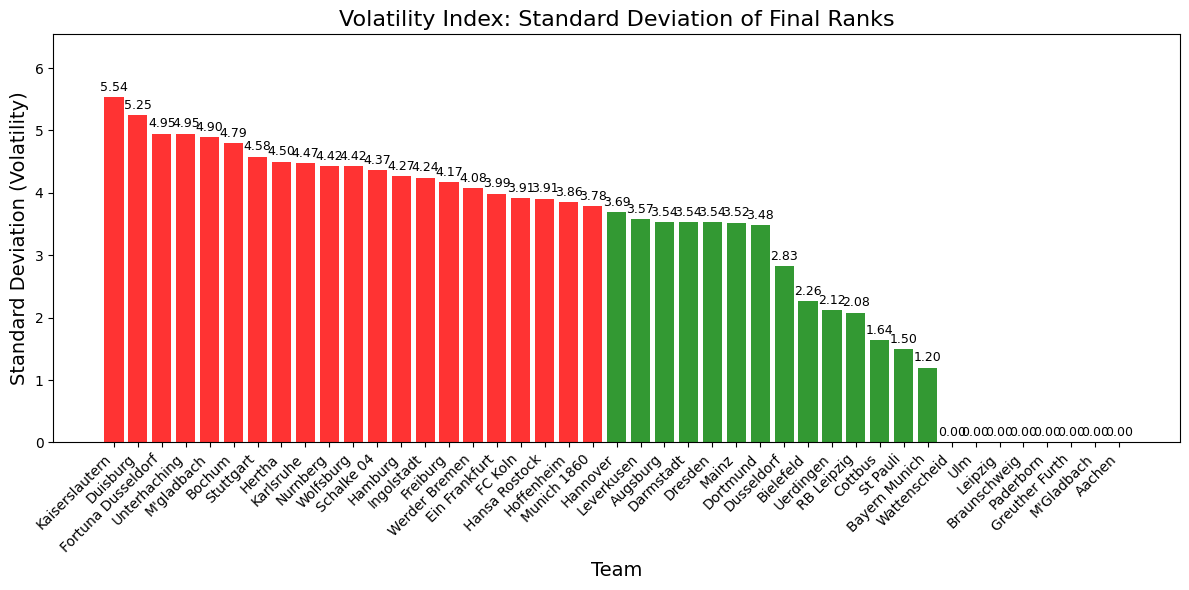

In [65]:
volatility = bundesliga2.groupby('TEAM')['POSITION'].std().reset_index()
volatility.columns = ['Team', 'Volatility']

volatility['Volatility'] = volatility['Volatility'].fillna(0)

volatility['Color'] = np.where(volatility['Volatility'] > np.median(volatility['Volatility']), 'red', 'green') 

volatility = volatility.sort_values('Volatility', ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(
    volatility['Team'], 
    volatility['Volatility'], 
    color=volatility['Color'], 
    alpha=0.8
)

## Part 4: Rivalries & Big Match Patterns
1. Head-to-Head Matrix for Selected Rivalries

• Select 5 key rivalries more info click here .

• Create a facet grid of win/draw/loss bar charts per rivalry.

• Annotate biggest win margins.

/var/folders/_1/__pt4n2j34s904855v8cbgkr0000gn/T/ipykernel_60330/1201462982.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rivalries["Goal_Diff"] = abs(df_rivalries["FTHG"] - df_rivalries["FTAG"])
/var/folders/_1/__pt4n2j34s904855v8cbgkr0000gn/T/ipykernel_60330/1201462982.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=subset, x="Result", ax=axes[i], palette={"Home Win": "blue", "Away Win": "red", "Draw": "gray"})
/var/folders/_1/__pt4n2j34s904855v8cbgkr0000gn/T/ipykernel_60330/1201462982.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will b

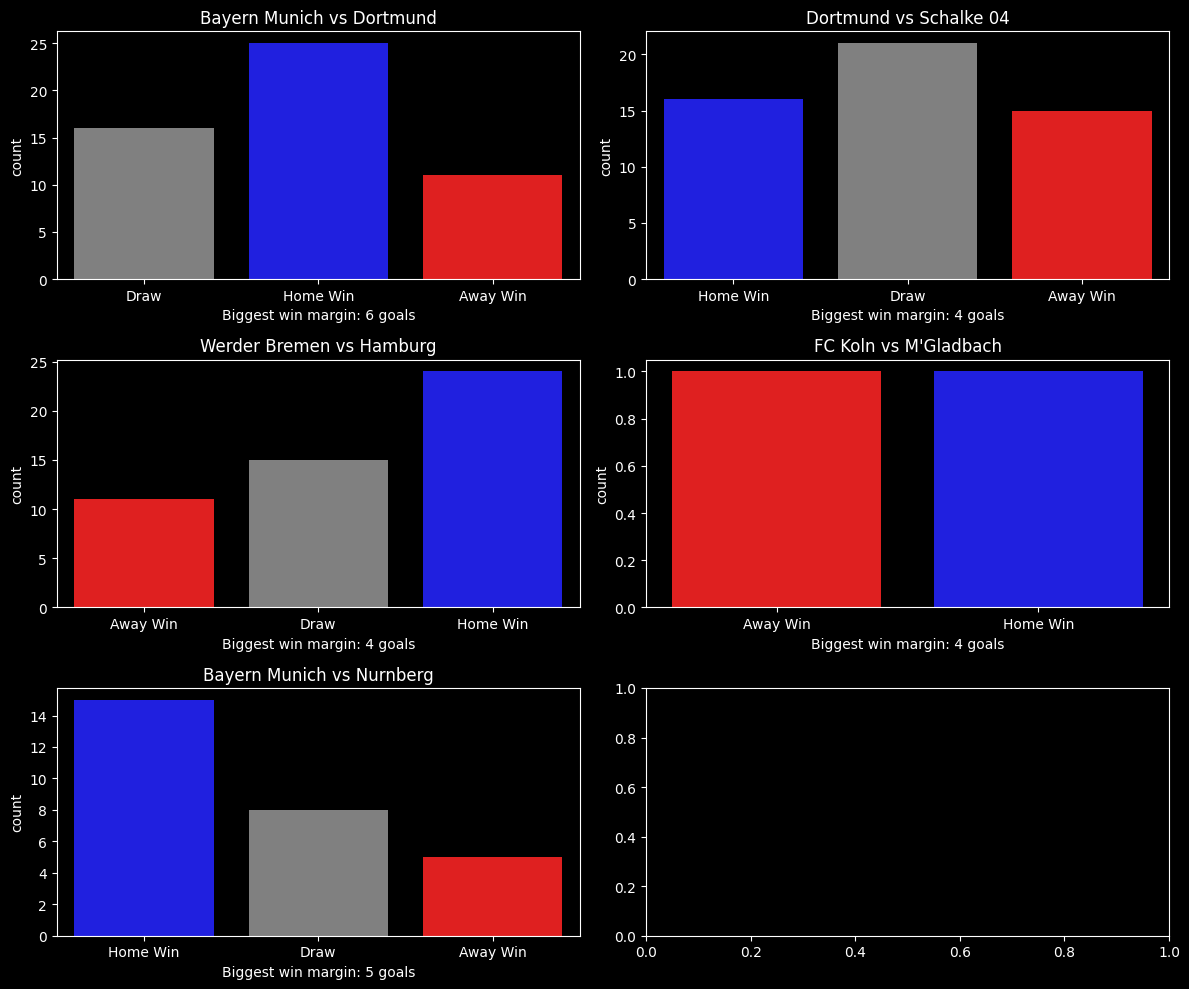

In [88]:
bundesliga["HOMETEAM"] = bundesliga["HOMETEAM"].str.strip()
bundesliga["AWAYTEAM"] = bundesliga["AWAYTEAM"].str.strip()

rivalries = [
    ("Bayern Munich", "Dortmund"),
    ("Dortmund", "Schalke 04"),
    ("Werder Bremen", "Hamburg"),
    ("FC Koln", "M'Gladbach"),
    ("Bayern Munich", "Nurnberg"),
]

def match_result(row):
    if row["FTHG"] > row["FTAG"]:
        return "Home Win"
    elif row["FTHG"] < row["FTAG"]:
        return "Away Win"
    else:
        return "Draw"

bundesliga["Result"] = bundesliga.apply(match_result, axis=1)

df_rivalries = bundesliga[bundesliga.apply(lambda row: {row["HOMETEAM"], row["AWAYTEAM"]} in map(set, rivalries), axis=1)]

for team1, team2 in rivalries:
    subset = df_rivalries[
        ((df_rivalries["HOMETEAM"] == team1) & (df_rivalries["AWAYTEAM"] == team2)) |
        ((df_rivalries["HOMETEAM"] == team2) & (df_rivalries["AWAYTEAM"] == team1))
    ]

df_rivalries["Goal_Diff"] = abs(df_rivalries["FTHG"] - df_rivalries["FTAG"])
biggest_wins = df_rivalries.loc[df_rivalries.groupby(["HOMETEAM", "AWAYTEAM"])["Goal_Diff"].idxmax()]

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (team1, team2) in enumerate(rivalries):
    subset = df_rivalries[
        ((df_rivalries["HOMETEAM"] == team1) & (df_rivalries["AWAYTEAM"] == team2)) |
        ((df_rivalries["HOMETEAM"] == team2) & (df_rivalries["AWAYTEAM"] == team1))
    ]

    if subset.empty:
        axes[i].set_title(f"{team1} vs {team2} (No Data)")
        axes[i].axis("off")
        continue

    sns.countplot(data=subset, x="Result", ax=axes[i], palette={"Home Win": "blue", "Away Win": "red", "Draw": "gray"})
    axes[i].set_title(f"{team1} vs {team2}")

    max_game = biggest_wins[
        ((biggest_wins["HOMETEAM"] == team1) & (biggest_wins["AWAYTEAM"] == team2)) |
        ((biggest_wins["HOMETEAM"] == team2) & (biggest_wins["AWAYTEAM"] == team1))
    ]

    if not max_game.empty:
        max_margin = int(max_game.iloc[0]["Goal_Diff"])
        axes[i].set_xlabel(f"Biggest win margin: {max_margin} goals")
        
plt.tight_layout()
plt.show()

2. Upset Visualizer

• Define “upset” as a team >8 places below beating a top-5 team.

• Scatterplot of upsets: x-axis = rank difference, y-axis = goal difference.

• Encode team colors; highlight and label famous upsets


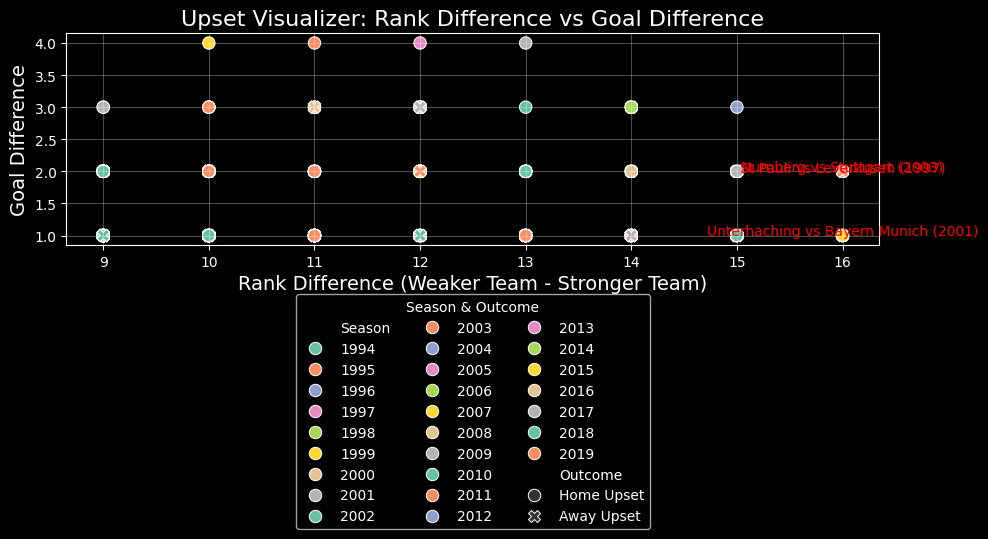

In [92]:
def get_top_5_teams(df, season, criterion):
    season_data = df[df["SEASON"] == season]
    if criterion == "Points":
        top_5 = season_data.nlargest(5, "POINTS")
    elif criterion == "Most Goals Scored":
        top_5 = season_data.nlargest(5, "GF")
    elif criterion == "Fewest Goals Conceded":
        top_5 = season_data.nsmallest(5, "GA")
    else:
        raise ValueError("Invalid criterion!")
    return top_5["TEAM"].tolist()

def filter_upsets(matches, standings, criterion="Points"):
    upsets = []
    for season in matches["SEASON"].unique():
        top_5 = get_top_5_teams(standings, season, criterion)
        
        season_matches = matches[matches["SEASON"] == season]
        for _, match in season_matches.iterrows():
            home_rank = standings[(standings["SEASON"] == season) & (standings["TEAM"] == match["HOMETEAM"])]["POSITION"].values[0]
            away_rank = standings[(standings["SEASON"] == season) & (standings["TEAM"] == match["AWAYTEAM"])]["POSITION"].values[0]
            if match["FTHG"] > match["FTAG"] and match["AWAYTEAM"] in top_5 and home_rank > away_rank + 8:
                rank_diff = home_rank - away_rank
                goal_diff = abs(match["FTHG"] - match["FTAG"])
                upsets.append({"Season": season, "Winner": match["HOMETEAM"], "Loser": match["AWAYTEAM"], 
                               "Rank Difference": rank_diff, "Goal Difference": goal_diff, "Outcome": "Home Upset"})
            elif match["FTAG"] > match["FTHG"] and match["HOMETEAM"] in top_5 and away_rank > home_rank + 8:
                rank_diff = away_rank - home_rank
                goal_diff = abs(match["FTAG"] - match["FTHG"])
                upsets.append({"Season": season, "Winner": match["AWAYTEAM"], "Loser": match["HOMETEAM"], 
                               "Rank Difference": rank_diff, "Goal Difference": goal_diff, "Outcome": "Away Upset"})
    return pd.DataFrame(upsets)

matches = pd.read_csv("bundesliga.csv")
standings = pd.read_csv("bundesliga2.csv") 

upsets = filter_upsets(matches, standings, criterion="Points")

famous_upsets = upsets.nlargest(3, "Rank Difference")

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=upsets, 
    x="Rank Difference", 
    y="Goal Difference", 
    hue="Season", 
    style="Outcome", 
    palette="Set2", 
    s=80
)

for _, upset in famous_upsets.iterrows():
    plt.text(
        upset["Rank Difference"], upset["Goal Difference"], 
        f"{upset['Winner']} vs {upset['Loser']} ({upset['Season']})", 
        fontsize=10, 
        color="red", 
        ha="center"
    )

plt.title("Upset Visualizer: Rank Difference vs Goal Difference", fontsize=16)
plt.xlabel("Rank Difference (Weaker Team - Stronger Team)", fontsize=14)
plt.ylabel("Goal Difference", fontsize=14)

plt.legend(title="Season & Outcome", bbox_to_anchor=(0.5, -0.2), loc="upper center", ncol=3, fontsize=10)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Part 5: Overall performance
• Define unique color for each team per season. For each season create horizontal bar plot using total
number of points. Highlighting the winner with the unique color that you assigned to it. Save all
graphs in pdf.

• Redo the same task in python. But instead of total points use goal difference. Use same logic for colors as in first part.

In [96]:
teams = bundesliga2["TEAM"].unique()
team_colors = dict(zip(teams, sns.color_palette("husl", n_colors=len(teams))))

def create_goal_difference_plot(season):
    season_data = bundesliga2[bundesliga2["SEASON"] == season]

    winner = season_data.loc[season_data["DIFF"].idxmax(), "TEAM"]

    season_data["Color"] = season_data["TEAM"].apply(
        lambda team: team_colors[team] if team == winner else "gray"
    )

    plt.figure(figsize=(12, 8))
    bars = plt.barh(
        season_data["TEAM"],
        season_data["DIFF"],
        color=season_data["Color"], 
        edgecolor="black"
    )
    
    plt.title(f"Goal Difference - Season {season}", fontsize=16)
    plt.xlabel("Goal Difference", fontsize=14)
    plt.ylabel("Teams", fontsize=14)

    for bar in bars:
        if bar.get_y() == season_data[season_data["TEAM"] == winner].index[0]:
            bar.set_edgecolor("gold")
            bar.set_linewidth(3)

    output_png = f"goal_difference_plot_{season}.png"
    plt.savefig(output_png, facecolor='white')  # Ensure white background
    plt.close()
    return output_png

output_pdf = "part5-python.pdf"
pdf = canvas.Canvas(output_pdf, pagesize=letter)

for season in bundesliga2["SEASON"].unique():
    png_file = create_goal_difference_plot(season)
    pdf.drawImage(png_file, x=30, y=100, width=550, height=400)
    pdf.showPage()

pdf.save()

/var/folders/_1/__pt4n2j34s904855v8cbgkr0000gn/T/ipykernel_60330/2820735637.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_data["Color"] = season_data["TEAM"].apply(
/var/folders/_1/__pt4n2j34s904855v8cbgkr0000gn/T/ipykernel_60330/2820735637.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_data["Color"] = season_data["TEAM"].apply(
/var/folders/_1/__pt4n2j34s904855v8cbgkr0000gn/T/ipykernel_60330/2820735637.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 